
# Bifurcation diagram of Nonlinear coupled 2D ODE

Bifurcation diagrams allow us to visualise the impact of parameters on the solutions.

You can read more about them [here](https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/08%3A_Bifurcations/8.02%3A_Bifurcations_in_1-D_Continuous-Time_Models).

This notebook uses [BifrucationKit.jl](https://bifurcationkit.github.io/BifurcationKitDocs.jl/dev/).

In [1]:
using BifurcationKit
using Plots, Revise

const BK = BifurcationKit

BifurcationKit

# Model definition

In [2]:
function x_dot!(dx, x, p, t=0)
    (;a) = p
    dx[1] = a * x[1] .- x[2] - x[1] .* (x[1].^2 .+ x[2].^2)
    dx[2] = x[1] .+ a .* x[2] - x[2] .* (x[1].^2 .+ x[2].^2)
    dx
end

x_dot! (generic function with 2 methods)

## Bifurcation Diagram in $h$

In [3]:
par = (a=0., )

(a = 0.0,)

In [4]:
prob1 = BifurcationProblem(
    x_dot!, 
    [0.1, -0.1], 
    par,
    (@optic _.a),   # Here we set the continuation parameter
    record_from_solution = (x, p; k...) -> x[1]
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace:  false
├─ Symmetric: false
└─ Parameter: a

In [5]:
continuation_bounds = ContinuationPar(
    p_min = -1., 
    p_max = 1., 
    nev=2)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.1
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 -1.0
  p_max: Float64 1.0
  max_steps: Int64 400
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 2
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 3
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 15
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [6]:
bd1 = continuation(prob1, 
    PALC(), 
    ContinuationPar(continuation_bounds; ds = -0.001, dsmax = 0.01, n_inversion = 8, detect_bifurcation = 3); 
    bothside = true)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 152
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter a starts at 1.0, ends at -1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at a ≈ +1.00000000,                                                                     step =   0
- #  2,     hopf at a ≈ +0.00000138 ∈ (-0.00000276, +0.00000138), |δp|=4e-06, [converged], δ = (-2, -2), step =  74
- #  3, endpoint at a ≈ -1.00000000,                                                                     step = 151


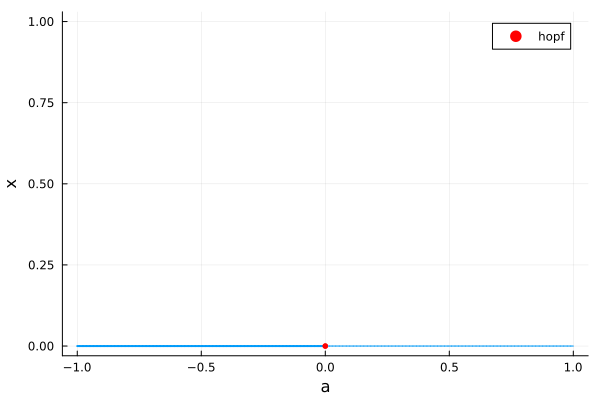

In [7]:
plot(bd1)

We see from the read out above that a hopf bifurcation is found. This means that a periodic solution exists and we want to continue along this. To produce a bifurcation diagram of periodic solutions you need to set up the continuation a little differently.

A periodic orbit will go through a series of values in $x_1$ and $x_2$. To plot this as a single value on a 2D diagram, we find the maximum norm of the periodic orbit. In other words, say the orbit is $\vec{x}(t)=(x_1(t), x_2(t))$ for $T> t \ge 0$, we plot $\max_{t\in[0,T)} ||\vec{x}(t)||$. Here we denote the period $T$.

In [8]:
# Definition of taking maximum norm
args_po = ( record_from_solution = (x, p; k...) -> begin
        xtt = get_periodic_orbit(p.prob, x, p.p)
        return (max = maximum(xtt[1,:]),
                min = minimum(xtt[1,:]),
                period = getperiod(p.prob, x, p.p))
    end)

#4 (generic function with 1 method)

In [9]:
# continuation parameters
opts_po_cont = ContinuationPar(
    dsmax = 0.01, 
    ds= 0.0001, 
    dsmin = 1e-4,
    tol_stability = 1e-4, 
    max_steps = 1000, 
    detect_bifurcation = 2 # <--- Key word used for tracking periodic orbits
);

In [10]:
br_pocoll = @time continuation(
    # we want to branch form the 2nd bif. point (1st and 3rd are end points)
    bd1, 2, opts_po_cont,
    PeriodicOrbitOCollProblem(50, 4; meshadapt = true);
    )

 33.662604 seconds (47.89 M allocations: 4.302 GiB, 5.77% gc time, 97.30% compilation time)


 ┌─ Curve type: PeriodicOrbitCont from Hopf bifurcation point.
 ├─ Number of points: 102
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter a starts at 0.00010138106793200491, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at a ≈ +1.00000000,                                                                     step = 101


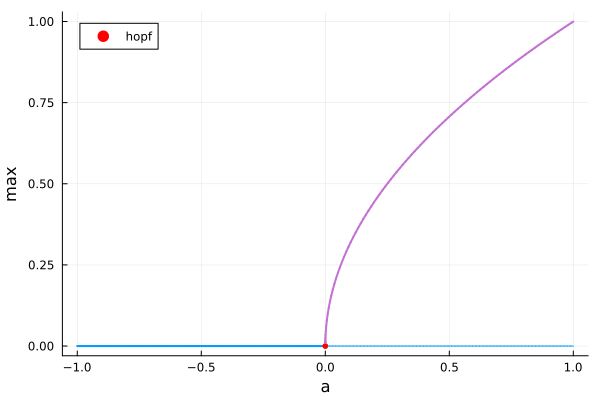

In [11]:
plot(bd1)
plot!(br_pocoll)